In [23]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [24]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [25]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [26]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-06-06,13387.08,13071.19,13254.77,154.87,2048523.04,13281.64
2020-06-07,13602.20,12942.77,13281.64,188.46,2490512.28,13366.81
2020-06-08,13594.36,12974.80,13366.81,266.04,3533707.82,13071.25
2020-06-09,13203.09,12884.03,13071.25,240.16,3131582.58,13123.31
2020-06-10,13370.88,11971.05,13123.31,187.86,2471596.59,13290.09


In [27]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [28]:
train, test = train_test_split(hist, test_size=0.2)

In [29]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

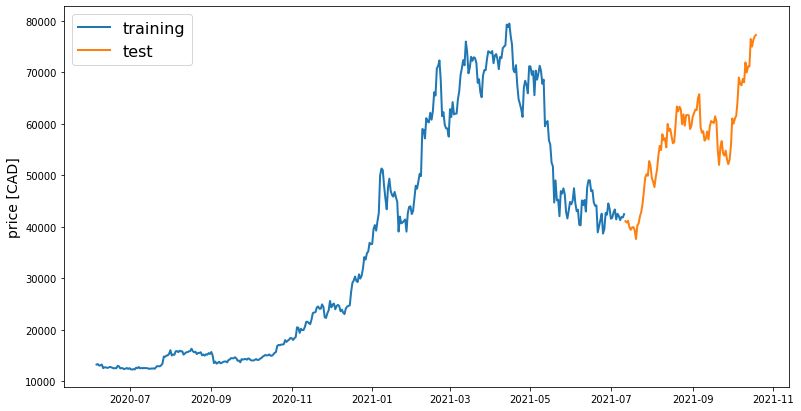

In [30]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [31]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [32]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [33]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [34]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [35]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [36]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [37]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 2s 39ms/step - loss: 0.0076 - val_loss: 0.0042
Epoch 2/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0067 - val_loss: 0.0219
Epoch 3/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0045 - val_loss: 0.0228
Epoch 4/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0160
Epoch 5/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0040 - val_loss: 0.0246
Epoch 6/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0055 - val_loss: 0.0244
Epoch 7/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0037 - val_loss: 0.0189
Epoch 8/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0171
Epoch 9/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0212
Epoch 10/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0034 - val_loss: 0.0146
Epoch 11/20
13/13 

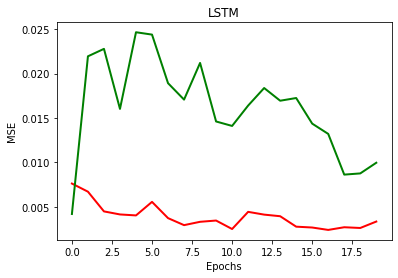

In [38]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [39]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.04651393303717234

In [40]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE


0.009951568510912799

In [41]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

-0.5084836690418078

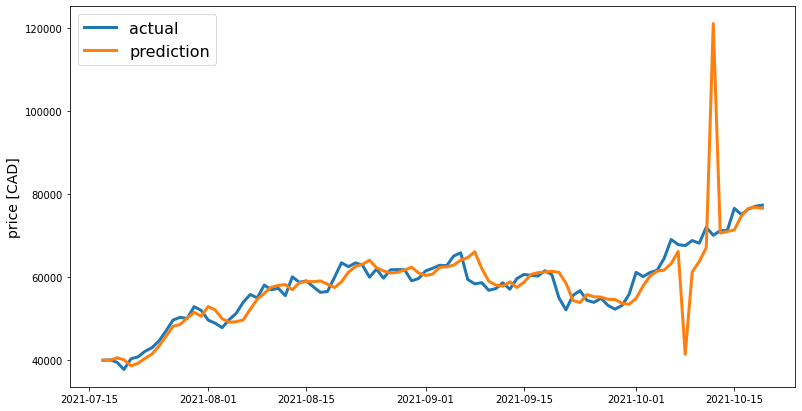

In [42]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)